In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import shuffle

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

import random
from random import randrange
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.0.0'

#### Check if tensorflow catch GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


#### Directory Parameters

In [4]:
base_dir = 'cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

IMG_WIDTH = 150
IMG_HEIGHT = 150

#### Examine the total images of cats and dogs respectively

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training cat images: 1000
total training dog images: 1000


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
X, y = train_generator.next()
y

array([1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

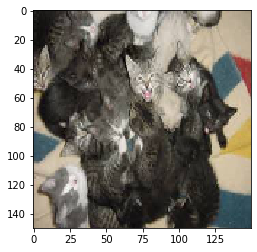

In [9]:
plt.imshow(X[2])

#### Load datasets into numpy format

In [10]:
def load_Datasets(_dir, label):
    files = [os.path.join(_dir, file) for file in os.listdir(_dir) if file.endswith(".jpg")]
    X = []
    y = []
    for file in files:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(IMG_WIDTH, IMG_HEIGHT))
        X.append(image)
        y.append(label)
    
    return np.array(X) / 255.0, np.array(y)

In [11]:
train_cat_data, train_cat_label = load_Datasets(train_cats_dir, "cat")
train_dog_data, train_dog_label = load_Datasets(train_dogs_dir, "dog")

valid_cat_data, valid_cat_label = load_Datasets(validation_cats_dir, "cat")
valid_dog_data, valid_dog_label = load_Datasets(validation_dogs_dir, "dog")

In [12]:
train_X = np.concatenate((train_cat_data, train_dog_data), axis=0)
train_y = np.concatenate((train_cat_label, train_dog_label), axis=0)
valid_X = np.concatenate((valid_cat_data, valid_dog_data), axis=0)
valid_y = np.concatenate((valid_cat_label, valid_dog_label), axis=0)

del train_cat_data, train_dog_data, valid_cat_data, valid_dog_data
del train_cat_label, train_dog_label, valid_cat_label, valid_dog_label

In [13]:
train_X.shape

(2000, 150, 150, 3)

In [14]:
data = {'Image': list(train_X), 'Label': train_y}
train_df = pd.DataFrame(data = data)

data = {'Image': list(valid_X), 'Label': valid_y}
valid_df = pd.DataFrame(data = data)

In [15]:
display(train_df.shape)
train_df.head()

(2000, 2)

,Image,Label
0,"[[[0.796078431372549, 0.6431372549019608, 0.34...",cat
1,"[[[0.15294117647058825, 0.17254901960784313, 0...",cat
2,"[[[0.11372549019607843, 0.12941176470588237, 0...",cat
3,"[[[0.8705882352941177, 0.8745098039215686, 0.8...",cat
4,"[[[0.2823529411764706, 0.996078431372549, 1.0]...",cat


In [16]:
train_df = shuffle(train_df, random_state = 1000)
display(train_df.shape)
train_df.head()

(2000, 2)

,Image,Label
82,"[[[0.23529411764705882, 0.16470588235294117, 0...",cat
1935,"[[[0.9176470588235294, 0.23137254901960785, 0....",dog
1639,"[[[0.5411764705882353, 0.4117647058823529, 0.4...",dog
1591,"[[[0.396078431372549, 0.41568627450980394, 0.3...",dog
1433,"[[[0.8392156862745098, 0.7411764705882353, 0.6...",dog


In [17]:
def label_numerize(y_lab):
    y_num = []
    for y in y_lab:
        if y == 'cat':
            y_num.append(0)
        else:
            y_num.append(1)
            
    return np.array(y_num)

In [18]:
train_X_np = train_df['Image'].values
valid_X_np = valid_df['Image'].values
train_y = train_df['Label'].values
valid_y = valid_df['Label'].values

train_y_num = label_numerize(train_y)
train_y_num = train_y_num.reshape(-1,1)
valid_y_num = label_numerize(valid_y)
valid_y_num = valid_y_num.reshape(-1,1)

del train_df, valid_df

In [19]:
train_X = []
for x in train_X_np:
    train_X.append(x)
    
train_X = np.asarray(train_X)
train_X.shape

(2000, 150, 150, 3)

In [20]:
valid_X = []
for x in valid_X_np:
    valid_X.append(x)
    
valid_X = np.asarray(valid_X)
valid_X.shape

(1000, 150, 150, 3)

'cat,dog,dog,dog,dog,cat,cat,cat,dog,dog,cat,dog,dog,cat,cat,cat,dog,dog,cat,cat,cat,cat,cat,dog,dog,dog,cat,cat,dog,dog,dog,dog,dog,cat,dog,dog,dog,dog,cat,cat,dog,dog,cat,dog,dog,dog,cat,cat,dog,cat,cat,dog,cat,cat,cat,cat,dog,dog,dog,cat,cat,cat,cat,dog'

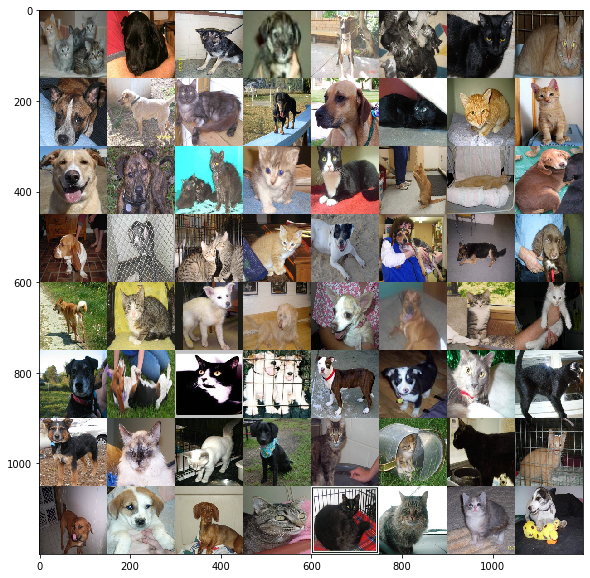

In [21]:
pltgrid = np.zeros((IMG_WIDTH * 8, IMG_HEIGHT * 8, 3))
idx = 0
labels = []
#print the first 64 images
for row in range(0, IMG_HEIGHT * 8, IMG_HEIGHT):
    for col in range(0, IMG_WIDTH * 8, IMG_WIDTH):
        pltgrid[row:row+IMG_WIDTH, col:col+IMG_HEIGHT, :] = train_X[idx]
        labels.append(train_y[idx])
        idx += 1

plt.figure(figsize=(10,10))
plt.imshow(pltgrid)
','.join(labels)

#### Image Augmentation

In [22]:
def flip_left_right(npImg):
    return tf.image.random_flip_left_right(npImg)

def change_color(npImg):
    npImg = tf.image.random_hue(npImg, 0.08)
    npImg = tf.image.random_saturation(npImg, 0.6, 1.6)
    npImg = tf.image.random_brightness(npImg, 0.05)
    npImg = tf.image.random_contrast(npImg, 0.7, 1.3)
    
    return npImg

def rotate(npImg):
    npImg = tf.image.rot90(npImg, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return npImg

def zoom(npImg, scale_min = 0.6, scale_max=1.4):
    wd, hgt, ch = npImg.shape
    scale = tf.random.uniform([], scale_min, scale_max)
    shgt = hgt * scale
    swd = wd * scale
    npImg = tf.image.resize(npImg, (swd, shgt))
    npImg = tf.image.resize_with_crop_or_pad(npImg, wd, hgt)
    
    return npImg

#### Demo those functions above

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


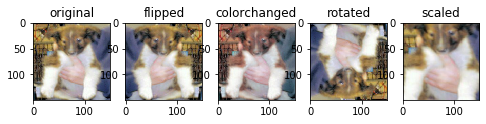

In [23]:
idx = randrange(train_X.shape[0])
Img = train_X[idx]
flipImg = flip_left_right(Img)
colorImg = change_color(Img)
rotImg = rotate(Img)
zoomImg = zoom(Img)

ImgList = [Img, flipImg, colorImg, rotImg, zoomImg]
desList = ['original', 'flipped', 'colorchanged', 'rotated', 'scaled']

plt.figure(figsize=(8,8))
for i in range(len(ImgList)):
    img = ImgList[i]
    desc = desList[i]
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(desc)
    
plt.show()

del ImgList
del Img, flipImg, colorImg, rotImg, zoomImg
del desList

In [24]:
def data_augmentation(X_train):
    iscolorchg = [True, False]
    isrotate = [True, False, False, False]
    iszoom = [True, False]
    
    for i in range(len(X_train)):
        # Randomly flip images
        X_train[i] = flip_left_right(X_train[i])
        
        if random.choice(iscolorchg) == True:
            # Randomly change the color of images with random rate 50%
            X_train[i] = change_color(X_train[i])
        if random.choice(isrotate) == True:
            # Randomly rotate the images with random rate 25%
            X_train[i] = rotate(X_train[i])
        if random.choice(iszoom) == True:
            # Randomly zoom the images with random rate 50%
            X_train[i] = zoom(X_train[i])
    
    return X_train

---
#### Train model without augmentation

In [25]:
def build_model(name):
    inputs = keras.Input(shape=(150, 150, 3))
    x = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(384, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(192, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name=name)
    model.summary()
    
    return model

In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
EPOCHS = 100
BATCH_SIZE = 86

In [27]:
model_dir = 'lab_logs/modelsAdam/'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [28]:
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/checkpoint.h5',
                                            monitor='val_binary_accuracy',
                                            save_best_only=True,
                                            mode='max')

In [29]:
model_adam = build_model('modelAdam')
model_adam.compile(keras.optimizers.Adam(),
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.BinaryAccuracy()])

Model: "modelAdam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 38, 64)        25

In [30]:
historyAdam = model_adam.fit(train_X, train_y_num,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       validation_data=(valid_X, valid_y_num),
                       callbacks=[learning_rate_reduction, model_mckp])

Train on 2000 samples, validate on 1000 samples
Epoch 1/100
2000/2000 [==============================] - 26s 13ms/sample - loss: 2.0219 - binary_accuracy: 0.5105 - val_loss: 0.7937 - val_binary_accuracy: 0.5010
Epoch 2/100
2000/2000 [==============================] - 14s 7ms/sample - loss: 1.6201 - binary_accuracy: 0.5575 - val_loss: 1.0604 - val_binary_accuracy: 0.5070
Epoch 3/100
2000/2000 [==============================] - 11s 5ms/sample - loss: 1.4039 - binary_accuracy: 0.5540 - val_loss: 0.8689 - val_binary_accuracy: 0.5130
Epoch 4/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.9319 - binary_accuracy: 0.5640 - val_loss: 0.7728 - val_binary_accuracy: 0.4860
Epoch 5/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.7826 - binary_accuracy: 0.5770 - val_loss: 1.0051 - val_binary_accuracy: 0.5000
Epoch 6/100
2000/2000 [==============================] - 11s 5ms/sample - loss: 0.7248 - binary_accuracy: 0.5825 - val_loss: 0.7111 - val_binar

Epoch 44/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0229 - binary_accuracy: 0.9950 - val_loss: 1.0327 - val_binary_accuracy: 0.7080
Epoch 45/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0210 - binary_accuracy: 0.9935 - val_loss: 1.0385 - val_binary_accuracy: 0.7110
Epoch 46/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0216 - binary_accuracy: 0.9935 - val_loss: 1.0413 - val_binary_accuracy: 0.7100
Epoch 47/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0144 - binary_accuracy: 0.9960 - val_loss: 1.0420 - val_binary_accuracy: 0.7120
Epoch 48/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0160 - binary_accuracy: 0.9965 - val_loss: 1.0410 - val_binary_accuracy: 0.7090
Epoch 49/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0151 - binary_accuracy: 0.9980 - val_loss: 1.0372 - val_binary_accuracy: 0.7040
Epoch 50/100
2000/2000 [====

2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0111 - binary_accuracy: 0.9980 - val_loss: 1.1152 - val_binary_accuracy: 0.7080
Epoch 95/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0091 - binary_accuracy: 0.9990 - val_loss: 1.1284 - val_binary_accuracy: 0.7080
Epoch 96/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0110 - binary_accuracy: 0.9980 - val_loss: 1.1377 - val_binary_accuracy: 0.7090
Epoch 97/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0093 - binary_accuracy: 0.9990 - val_loss: 1.1305 - val_binary_accuracy: 0.7080
Epoch 98/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0117 - binary_accuracy: 0.9975 - val_loss: 1.1235 - val_binary_accuracy: 0.7070
Epoch 99/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0128 - binary_accuracy: 0.9965 - val_loss: 1.1105 - val_binary_accuracy: 0.7060
Epoch 100/100
2000/2000 [================

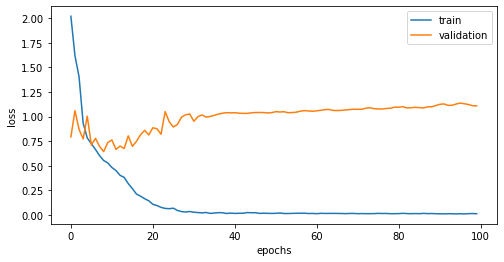

In [31]:
plt.figure(figsize=(8,4))
plt.plot(historyAdam.history['loss'], label='train')
plt.plot(historyAdam.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

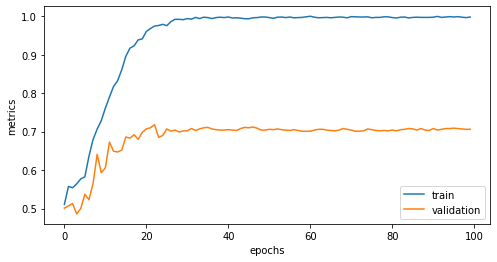

In [32]:
plt.figure(figsize=(8,4))
plt.plot(historyAdam.history['binary_accuracy'], label='train')
plt.plot(historyAdam.history['val_binary_accuracy'], label='validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()

In [33]:
model_dir = 'lab_logs/modelsRMSprop/'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [34]:
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/checkpoint.h5',
                                            monitor='val_categorical_accuracy',
                                            save_best_only=True,
                                            mode='max')

In [35]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rms = build_model('modelRMSprop')
model_rms.compile(optimizer = optimizer,
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.BinaryAccuracy()])

Model: "modelRMSprop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      4864      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 38, 38, 64)       

In [36]:
historyRMS = model_adam.fit(train_X, train_y_num,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       validation_data=(valid_X, valid_y_num),
                       callbacks=[learning_rate_reduction, model_mckp])

Train on 2000 samples, validate on 1000 samples
Epoch 1/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0127 - binary_accuracy: 0.9965 - val_loss: 1.1135 - val_binary_accuracy: 0.7080
Epoch 2/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0115 - binary_accuracy: 0.9975 - val_loss: 1.1233 - val_binary_accuracy: 0.7080
Epoch 3/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0112 - binary_accuracy: 0.9985 - val_loss: 1.1320 - val_binary_accuracy: 0.7050
Epoch 4/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0114 - binary_accuracy: 0.9975 - val_loss: 1.1120 - val_binary_accuracy: 0.7040
Epoch 5/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0086 - binary_accuracy: 0.9990 - val_loss: 1.1144 - val_binary_accuracy: 0.7050
Epoch 6/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0093 - binary_accuracy: 0.9985 - val_loss: 1.1264 - val_binary_acc

2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0097 - binary_accuracy: 0.9960 - val_loss: 1.1599 - val_binary_accuracy: 0.7090
Epoch 25/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0100 - binary_accuracy: 0.9965 - val_loss: 1.1585 - val_binary_accuracy: 0.7090
Epoch 26/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0099 - binary_accuracy: 0.9980 - val_loss: 1.1391 - val_binary_accuracy: 0.7080
Epoch 27/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0088 - binary_accuracy: 0.9980 - val_loss: 1.1465 - val_binary_accuracy: 0.7060
Epoch 28/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0071 - binary_accuracy: 0.9990 - val_loss: 1.1584 - val_binary_accuracy: 0.7070
Epoch 29/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0077 - binary_accuracy: 0.9995 - val_loss: 1.1666 - val_binary_accuracy: 0.7070
Epoch 30/100
2000/2000 [=================

2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0078 - binary_accuracy: 0.9985 - val_loss: 1.2011 - val_binary_accuracy: 0.7080
Epoch 48/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0081 - binary_accuracy: 0.9980 - val_loss: 1.1920 - val_binary_accuracy: 0.7100
Epoch 49/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0064 - binary_accuracy: 0.9990 - val_loss: 1.1986 - val_binary_accuracy: 0.7070
Epoch 50/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0083 - binary_accuracy: 0.9975 - val_loss: 1.1829 - val_binary_accuracy: 0.7040
Epoch 51/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0068 - binary_accuracy: 0.9990 - val_loss: 1.1693 - val_binary_accuracy: 0.7020
Epoch 52/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0062 - binary_accuracy: 0.9990 - val_loss: 1.1732 - val_binary_accuracy: 0.7040
Epoch 53/100
2000/2000 [=================

Epoch 71/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0055 - binary_accuracy: 0.9995 - val_loss: 1.2272 - val_binary_accuracy: 0.7080
Epoch 72/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0074 - binary_accuracy: 0.9970 - val_loss: 1.2269 - val_binary_accuracy: 0.7070
Epoch 73/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0047 - binary_accuracy: 0.9995 - val_loss: 1.2333 - val_binary_accuracy: 0.7050
Epoch 74/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0066 - binary_accuracy: 0.9985 - val_loss: 1.2424 - val_binary_accuracy: 0.7080
Epoch 75/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0063 - binary_accuracy: 0.9975 - val_loss: 1.2439 - val_binary_accuracy: 0.7060
Epoch 76/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0063 - binary_accuracy: 0.9995 - val_loss: 1.2353 - val_binary_accuracy: 0.7060
Epoch 77/100
2000/2000 [====

2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0059 - binary_accuracy: 0.9980 - val_loss: 1.2824 - val_binary_accuracy: 0.7060
Epoch 95/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0050 - binary_accuracy: 0.9990 - val_loss: 1.2794 - val_binary_accuracy: 0.7070
Epoch 96/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0047 - binary_accuracy: 0.9995 - val_loss: 1.2692 - val_binary_accuracy: 0.7030
Epoch 97/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0030 - binary_accuracy: 1.0000 - val_loss: 1.2623 - val_binary_accuracy: 0.7050
Epoch 98/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0053 - binary_accuracy: 0.9995 - val_loss: 1.2681 - val_binary_accuracy: 0.7030
Epoch 99/100
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.0036 - binary_accuracy: 1.0000 - val_loss: 1.2763 - val_binary_accuracy: 0.7040
Epoch 100/100
2000/2000 [================

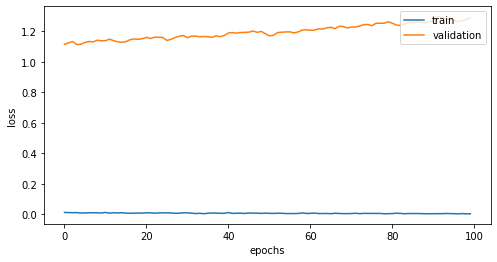

In [37]:
plt.figure(figsize=(8,4))
plt.plot(historyRMS.history['loss'], label='train')
plt.plot(historyRMS.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

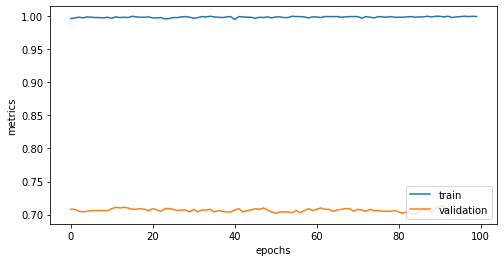

In [38]:
plt.figure(figsize=(8,4))
plt.plot(historyRMS.history['binary_accuracy'], label='train')
plt.plot(historyRMS.history['val_binary_accuracy'], label='validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()

---
#### Train model with augmentation

In [39]:
TIMES = 2
initialX = train_X.copy()
initialY = train_y.copy()

for i in range(TIMES):
    temp = initialX.copy()
    temp = data_augmentation(temp)
    train_X = np.concatenate((train_X, temp), axis=0)
    train_y = np.concatenate((train_y, initialY), axis=0)

In [46]:
train_y_num = label_numerize(train_y)
train_y_num = train_y_num.reshape(-1,1)
display(train_X.shape)
display(train_y_num.shape)

(6000, 150, 150, 3)

(6000, 1)

In [47]:
model_dir = 'lab_logs/modelsAdamAug/'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [48]:
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/checkpoint.h5',
                                            monitor='val_binary_accuracy',
                                            save_best_only=True,
                                            mode='max')

In [49]:
model_adam = build_model('modelAdamAug')
model_adam.compile(keras.optimizers.Adam(),
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.BinaryAccuracy()])

Model: "modelAdamAug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 38, 38, 64)       

In [50]:
historyAdam = model_adam.fit(train_X, train_y_num,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       validation_data=(valid_X, valid_y_num),
                       callbacks=[learning_rate_reduction, model_mckp])

Train on 6000 samples, validate on 1000 samples
Epoch 1/100
6000/6000 [==============================] - 34s 6ms/sample - loss: 2.0585 - binary_accuracy: 0.5262 - val_loss: 0.9374 - val_binary_accuracy: 0.5050
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/sample - loss: 0.9736 - binary_accuracy: 0.5457 - val_loss: 0.6973 - val_binary_accuracy: 0.5370
Epoch 3/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.7515 - binary_accuracy: 0.5643 - val_loss: 0.7165 - val_binary_accuracy: 0.5120
Epoch 4/100
6000/6000 [==============================] - 29s 5ms/sample - loss: 0.6618 - binary_accuracy: 0.6158 - val_loss: 0.6930 - val_binary_accuracy: 0.5490
Epoch 5/100
6000/6000 [==============================] - 29s 5ms/sample - loss: 0.6329 - binary_accuracy: 0.6437 - val_loss: 0.6906 - val_binary_accuracy: 0.6040
Epoch 6/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.6070 - binary_accuracy: 0.6670 - val_loss: 0.7119 - val_bina

5934/6000 [============================>.] - ETA: 0s - loss: 0.0047 - binary_accuracy: 0.9988
Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-05.
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0047 - binary_accuracy: 0.9988 - val_loss: 1.1765 - val_binary_accuracy: 0.7540
Epoch 45/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0045 - binary_accuracy: 0.9992 - val_loss: 1.1700 - val_binary_accuracy: 0.7580
Epoch 46/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0057 - binary_accuracy: 0.9988 - val_loss: 1.1725 - val_binary_accuracy: 0.7580
Epoch 47/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0045 - binary_accuracy: 0.9988 - val_loss: 1.1713 - val_binary_accuracy: 0.7580
Epoch 48/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0058 - binary_accuracy: 0.9987 - val_loss: 1.1739 - val_binary_accuracy: 0.7570
Epoch 49/100
6000/6000 [================

6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0025 - binary_accuracy: 0.9995 - val_loss: 1.2860 - val_binary_accuracy: 0.7610
Epoch 94/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0022 - binary_accuracy: 0.9995 - val_loss: 1.2857 - val_binary_accuracy: 0.7580
Epoch 95/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0033 - binary_accuracy: 0.9987 - val_loss: 1.2959 - val_binary_accuracy: 0.7600
Epoch 96/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0033 - binary_accuracy: 0.9995 - val_loss: 1.3037 - val_binary_accuracy: 0.7620
Epoch 97/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0022 - binary_accuracy: 0.9997 - val_loss: 1.2974 - val_binary_accuracy: 0.7600
Epoch 98/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0028 - binary_accuracy: 0.9995 - val_loss: 1.3012 - val_binary_accuracy: 0.7550
Epoch 99/100
6000/6000 [===========

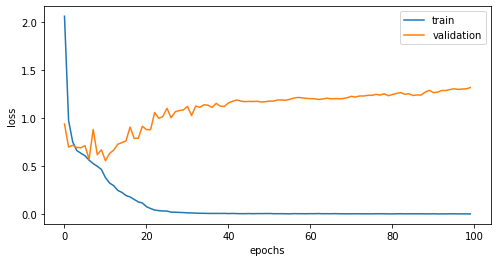

In [51]:
plt.figure(figsize=(8,4))
plt.plot(historyAdam.history['loss'], label='train')
plt.plot(historyAdam.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

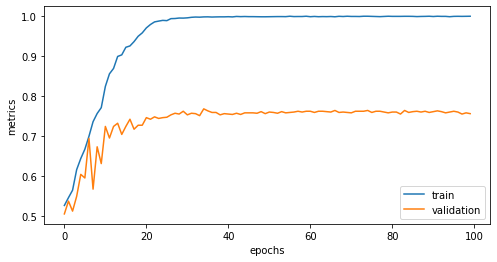

In [52]:
plt.figure(figsize=(8,4))
plt.plot(historyAdam.history['binary_accuracy'], label='train')
plt.plot(historyAdam.history['val_binary_accuracy'], label='validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()

In [53]:
model_dir = 'lab_logs/modelsRMSpropAug/'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [54]:
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/checkpoint.h5',
                                            monitor='val_binary_accuracy',
                                            save_best_only=True,
                                            mode='max')

In [55]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rms = build_model('modelRMSpropAug')
model_rms.compile(optimizer = optimizer,
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.BinaryAccuracy()])

Model: "modelRMSpropAug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 64)      4864      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        102464    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 38, 38, 64)    

In [56]:
historyRMS = model_adam.fit(train_X, train_y_num,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       validation_data=(valid_X, valid_y_num),
                       callbacks=[learning_rate_reduction, model_mckp])

Train on 6000 samples, validate on 1000 samples
Epoch 1/100
6000/6000 [==============================] - 29s 5ms/sample - loss: 0.0025 - binary_accuracy: 0.9992 - val_loss: 1.2995 - val_binary_accuracy: 0.7600
Epoch 2/100
6000/6000 [==============================] - 29s 5ms/sample - loss: 0.0022 - binary_accuracy: 0.9998 - val_loss: 1.3094 - val_binary_accuracy: 0.7610
Epoch 3/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0033 - binary_accuracy: 0.9993 - val_loss: 1.3691 - val_binary_accuracy: 0.7530
Epoch 4/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0027 - binary_accuracy: 0.9995 - val_loss: 1.3300 - val_binary_accuracy: 0.7580
Epoch 5/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0036 - binary_accuracy: 0.9988 - val_loss: 1.3071 - val_binary_accuracy: 0.7600
Epoch 6/100
6000/6000 [==============================] - 29s 5ms/sample - loss: 0.0022 - binary_accuracy: 0.9998 - val_loss: 1.3277 - val_bina

Epoch 51/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0014 - binary_accuracy: 0.9995 - val_loss: 1.4303 - val_binary_accuracy: 0.7630
Epoch 52/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0017 - binary_accuracy: 0.9995 - val_loss: 1.4494 - val_binary_accuracy: 0.7660
Epoch 53/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0021 - binary_accuracy: 0.9993 - val_loss: 1.4438 - val_binary_accuracy: 0.7650
Epoch 54/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 0.0013 - binary_accuracy: 0.9997 - val_loss: 1.4330 - val_binary_accuracy: 0.7700
Epoch 55/100
6000/6000 [==============================] - 25s 4ms/sample - loss: 6.9563e-04 - binary_accuracy: 1.0000 - val_loss: 1.4411 - val_binary_accuracy: 0.7670
Epoch 56/100
6000/6000 [==============================] - 26s 4ms/sample - loss: 0.0011 - binary_accuracy: 0.9998 - val_loss: 1.4739 - val_binary_accuracy: 0.7570
Epoch 57/100
6000/

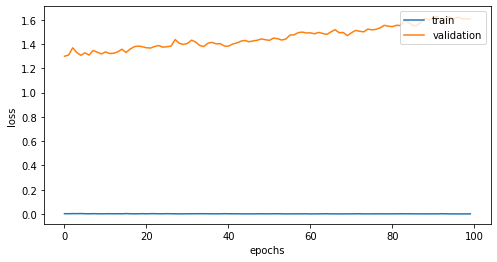

In [57]:
plt.figure(figsize=(8,4))
plt.plot(historyRMS.history['loss'], label='train')
plt.plot(historyRMS.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

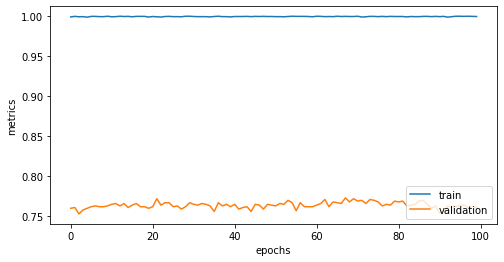

In [58]:
plt.figure(figsize=(8,4))
plt.plot(historyRMS.history['binary_accuracy'], label='train')
plt.plot(historyRMS.history['val_binary_accuracy'], label='validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()